Input
* gene signatures
* peak signatures <-- unique to this TF-Region-TG notebook
* Constructed Scenicpluc network
* adata with gene expression data

What this notebook does
* Get expressing genes with a threshold set
* Construct TF-TG network
    - Target gene: genes of interest
    - all TFs need to be "expressed genes"
    - TFs which indirectly target the "target genes" are also included (TF -> TF -> Target gene)
    - For each interaction (TF - Region - Gene), <u>either TF or Redion need to be "signature"</u> of the cell population of interest
* Calculate metrices
    - Centrality

In [1]:
# Parameters
working_dir = "/nfs/team205/heart/Vitro/TF_selection"
path_to_adata_gex = '/nfs/team205/heart/anndata_objects/Foetal/vCM/post_scFate/foetal_vCM_onlyLeft.h5ad'
path_to_adata_peak_tfidf = "/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/PeakMatrix/Foetal_Peaks_tfidf.h5ad"
group_key = "t_binned"
group_a = "t3"
group_b = "t1"
time_key = "t"
subset_object = False
geneset_list = ["MSigDB_Hallmark_2020", "KEGG_2021_Human", "GO_Biological_Process_2023"]

path_to_eRegulon_signatures_gene = "/nfs/team205/heart/pyscenic/plus/eRegulon_signatures/vCM_onlyLeft_Gene_eRegulon_signatures.pkl"
path_to_eRegulon_signatures_region = "/nfs/team205/heart/pyscenic/plus/eRegulon_signatures/vCM_onlyLeft_Region_eRegulon_signatures.pkl"

path_to_DAR_compact = '/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/MarkerPeaks/vCM_Left_Compact-vs-Trab.csv'
path_to_DAR_trab = '/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/MarkerPeaks/vCM_Left_Trab-vs-Compact.csv'
path_to_eRegulon_metadata = "/nfs/team205/heart/pyscenic/plus/eRegulon_metadata/vCM_onlyLeft_eRegulon_metadata_filtered.csv" # filtered metadata

path_to_gene_signatures = '/nfs/team205/heart/Vitro/TF_selection/foetal_vCM_left_compact-vs-trabeculated_downstream/gene_signatures.pkl'
path_to_peak_signatures = '/nfs/team205/heart/Vitro/TF_selection/foetal_vCM_left_compact-vs-trabeculated_downstream/peak_signatures.pkl'

###### parameters for TF selection for the population ######
cell_of_intest = 'VentricularCardiomyocytesLeftCompact'
target_signatures = ['compact_specific_up','common_up']

# proportion threshold for expressing genes
exp_prop_thresh = 0.1

# proportion threshold for accesible regions
access_prop_thresh = 0.01

In [34]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [3]:
import session_info
session_info.show()

In [4]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/regulon_plot.py")
regulon_plot = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = regulon_plot
spec.loader.exec_module(regulon_plot)

In [5]:
sc.settings.set_figure_params(dpi=120)

# Read in inputs

## Read in gene signatures and define target genes

In [6]:
gene_signatures = utils.read_pkl(path_to_gene_signatures)
gene_signatures.keys()

dict_keys(['compact_specific_up', 'trab_specific_up', 'common_up', 'compact_specific_down', 'trab_specific_down', 'common_down'])

In [7]:
sig_genes = []
for sig in target_signatures:
    print(sig)
    sig_genes = sig_genes + gene_signatures[sig]
print(len(sig_genes))
sig_genes[:5]

compact_specific_up
common_up
466


['KIDINS220', 'ANKRD18A', 'MT-ATP6', 'ZNF385D', 'VEGFA']

## Read in peak signatures

In [8]:
peak_signatures = utils.read_pkl(path_to_peak_signatures)
peak_signatures.keys()

dict_keys(['compact_up', 'trab_up', 'compact_down', 'trab_down'])

In [9]:
sig_peaks = peak_signatures['compact_up']
print(len(sig_peaks))
sig_peaks[:5]

4483


['chr1:240234383_240234883',
 'chr9:93673338_93673838',
 'chr22:42772683_42773183',
 'chr12:48124648_48125148',
 'chr12:46438700_46439200']

## Read in scenicplus output metadata

In [10]:
# scenicplus output
scenic_meta = pd.read_csv(path_to_eRegulon_metadata,index_col=0)
scenic_meta['Region'] = [x.replace('-','_') for x in scenic_meta['Region']]

# select 
scenic_meta.head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,AR_+_(10r),AR_+_(10g),AR,False,chr3:16301014_16301514,DPH3,0.060971,0.069418,0.004233,0.004233,3.403592,1,0.102801,0.349891,0.349891,AR_+_+
1,AR_+_(10r),AR_+_(10g),AR,False,chr6:132084769_132085269,CCN2,0.172997,0.335767,0.058087,0.058087,1.026187,1,0.139728,0.143387,0.143387,AR_+_+
2,AR_+_(10r),AR_+_(10g),AR,False,chr22:50274266_50274766,TUBGCP6,0.025944,0.139407,0.003617,0.003617,0.483614,1,0.092754,0.044857,0.044857,AR_+_+
3,AR_+_(10r),AR_+_(10g),AR,False,chr16:70391807_70392307,DDX19A,0.046559,0.156978,0.007309,0.007309,1.423411,1,0.052873,0.075260,0.075260,AR_+_+
4,AR_+_(10r),AR_+_(10g),AR,False,chr1:11885946_11886446,C1orf167,0.015392,0.067458,0.001038,0.001038,0.479298,1,0.078071,0.037419,0.037419,AR_+_+


## Read in and prepare anndata contains gene expression

In [12]:
# read in adata
# whole data
adata = sc.read_h5ad(path_to_adata_gex)

# subset gene expression data
adata = adata[:,adata.var['modality']=='Gene Expression']

# filter and log-normalise
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print(adata.X.data[:10])
adata

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


[1.0619993 1.5653387 1.8985853 1.5653387 2.347629  1.8985853 1.5653387
 1.0619993 1.0619993 1.0619993]


AnnData object with n_obs × n_vars = 16451 × 26187
    obs: 'sangerID', 'combinedID', 'donor', 'region', 'age', 'sex', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'week', 'trimester', 'cycling', 'S_score', 'G2M_score', 'phase', 'fine_grain', 'mid_grain', 'coarse_grain', 'batch_key', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', '_indices', '_scvi_batch', '_scvi_labels', 'leiden_MultiVI', 't', 'seg', 'edge', 'milestones', 'age_days', 'week_cont'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N', 'n_cells'
    uns: '_scvi_manager_uu

## Read in cardiomyocyte markers 

In [13]:
# read in major TF list
markers = pd.read_csv('./Gene_markers_Maturation.csv')
print(markers.shape)
markers.head()

# get non-TF markers (since this will overlap with centrality calculation based on TF-TF network)
marker_genes = list(markers[markers['Category']!='TF']['Gene'])
print(f'number of marker genes: {len(marker_genes)}')

# known TFs
TFs_known = list(markers[markers['Category']=='TF']['Gene'])
print(f'number of known TFs: {len(TFs_known)}')
TFs_known

(44, 4)
number of marker genes: 35
number of known TFs: 9


['MEF2A',
 'MEF2C',
 'TBX20',
 'NKX2-5',
 'HEY2',
 'PRDM16',
 'PPARA',
 'RORA',
 'THRA']

# Obtain expressing genes and accessible regions

## Genes

In [14]:
# get expression proportions
exp_mat = utils.get_exp_proportion(adata,groupby='fine_grain', use_rep='X')
exp_genes = list(exp_mat.index[exp_mat[cell_of_intest]>exp_prop_thresh])
len(exp_genes)

5212

In [15]:
'PRDM16' in exp_genes

True

## Peaks

In [16]:
adata_peak = sc.read_h5ad(path_to_adata_peak_tfidf)
adata_peak

AnnData object with n_obs × n_vars = 167022 × 508040
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

In [17]:
# get accessible proportions
access_mat = utils.get_exp_proportion(adata_peak,groupby='fine_grain', use_rep='X')

In [18]:
access_peaks = list(access_mat.index[access_mat[cell_of_intest]>access_prop_thresh])
len(access_peaks)

155246

# Prepare scenic metadata

In [19]:
# add columns to scenicplus metadata
# scenic_meta['Gene_isTF'] = scenic_meta['Gene'].isin(list(set(scenic_meta['TF'])))
scenic_meta['TF_isExp'] = scenic_meta['TF'].isin(exp_genes)
scenic_meta['TF_isSignature'] = (scenic_meta['TF'].isin(sig_genes))&(scenic_meta['TF'].isin(exp_genes))
scenic_meta['Region_isAccess'] = scenic_meta['Region'].isin(access_peaks)
scenic_meta['Region_isSignature'] = (scenic_meta['Region'].isin(sig_peaks))&(scenic_meta['Region'].isin(access_peaks))
scenic_meta.head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name,TF_isExp,TF_isSignature,Region_isAccess,Region_isSignature
0,AR_+_(10r),AR_+_(10g),AR,False,chr3:16301014_16301514,DPH3,0.060971,0.069418,0.004233,0.004233,3.403592,1,0.102801,0.349891,0.349891,AR_+_+,False,False,False,False
1,AR_+_(10r),AR_+_(10g),AR,False,chr6:132084769_132085269,CCN2,0.172997,0.335767,0.058087,0.058087,1.026187,1,0.139728,0.143387,0.143387,AR_+_+,False,False,True,False
2,AR_+_(10r),AR_+_(10g),AR,False,chr22:50274266_50274766,TUBGCP6,0.025944,0.139407,0.003617,0.003617,0.483614,1,0.092754,0.044857,0.044857,AR_+_+,False,False,True,False
3,AR_+_(10r),AR_+_(10g),AR,False,chr16:70391807_70392307,DDX19A,0.046559,0.156978,0.007309,0.007309,1.423411,1,0.052873,0.075260,0.075260,AR_+_+,False,False,True,False
4,AR_+_(10r),AR_+_(10g),AR,False,chr1:11885946_11886446,C1orf167,0.015392,0.067458,0.001038,0.001038,0.479298,1,0.078071,0.037419,0.037419,AR_+_+,False,False,True,True


In [35]:
# save the modified metadata
scenic_meta.to_csv(os.path.join(table_dir,'csvs/scenicplus_eRegulon_metadata_vCM_onlyLeft_modified.csv'))

In [36]:
os.path.join(table_dir,'csvs/scenicplus_eRegulon_metadata_vCM_onlyLeft_modified.csv')

'/nfs/team205/heart/fetal_ms_figures/tables/csvs/scenicplus_eRegulon_metadata_vCM_onlyLeft_modified.csv'

# Select interactions

In [20]:
target_genes = sig_genes.copy()
print(len(target_genes))
target_genes[:5]
# removing TFs from the list

466


['KIDINS220', 'ANKRD18A', 'MT-ATP6', 'ZNF385D', 'VEGFA']

In [20]:
# ionchannel = list(pd.read_csv('/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID177_Ion-channels.txt',sep='\t')['Approved symbol'].unique())
# gpcr = list(pd.read_csv('/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID139_G-protein-coupled-receptors.txt',sep='\t')['Approved symbol'].unique())

In [21]:
# select interactions

# select interaction which target "target_genes"
scenic_meta_sel = scenic_meta[(scenic_meta['Gene'].isin(target_genes))&\
                               scenic_meta['TF_isExp'] &\
                               scenic_meta['Region_isAccess'] &\
                              (scenic_meta['TF_isSignature']|scenic_meta['Region_isSignature'])
                             ]

# get TFs and target genes in the selected interaction
direct_TFs = list(set(scenic_meta_sel['TF']))
targets = list(set(scenic_meta_sel['Gene']))
# remove TFs already in target genes
TFs_sel = list(set(direct_TFs) - set(targets))

print(len(TFs_sel))
print(f'direct TFs: {direct_TFs}')
print('')

# select higher level interactions 
print('Start looking for higher level TFs')
higher_level_TFs = []
while len(TFs_sel)>0:
    scenic_meta_sel2 = scenic_meta[(scenic_meta['Gene'].isin(TFs_sel))&\
                               scenic_meta['TF_isExp'] &\
                               scenic_meta['Region_isAccess'] &\
                              (scenic_meta['TF_isSignature']|scenic_meta['Region_isSignature'])
                                  ]
    higher_level_TFs = higher_level_TFs + list(set(scenic_meta_sel2['TF']))
    if len(scenic_meta_sel2)>0:
        # concatenate
        scenic_meta_sel = pd.concat([scenic_meta_sel,scenic_meta_sel2])
        scenic_meta_sel = scenic_meta_sel.drop_duplicates()
        # get TFs and target genes in the selected interaction
        TFs_sel = list(set(scenic_meta_sel['TF']))
        targets = list(set(scenic_meta_sel['Gene']))
        # remove TFs already in target genes
        TFs_sel = list(set(TFs_sel) - set(targets))
        print(f'{len(TFs_sel)}: {TFs_sel}')
    else:
        print('no more higher level TFs')
        TFs_sel = []

scenic_meta_sel['direct_TF'] = scenic_meta_sel['TF'].isin(direct_TFs)
higher_level_TFs = list(set(higher_level_TFs)-set(direct_TFs))

# reindex
scenic_meta_sel.index = range(len(scenic_meta_sel))

print("")
print(f'Number of selected interactions: {len(scenic_meta_sel)}')
print(f"Number of TFs: {len(set(scenic_meta_sel['TF']))}")

44
direct TFs: ['TFCP2', 'ZNF280D', 'AHCTF1', 'MEIS2', 'NFATC2', 'ZBTB20', 'UBP1', 'NPAS2', 'KLF12', 'SREBF2', 'MAX', 'HMBOX1', 'ESRRB', 'NR3C1', 'HAND2', 'CREB1', 'PHF21A', 'SOX5', 'ZBTB16', 'THRA', 'MEF2D', 'RORA', 'TGIF2', 'ARID3A', 'KLF6', 'MXI1', 'PLAG1', 'BHLHE40', 'ESRRA', 'NFIB', 'MEF2A', 'FOXK1', 'GTF2IRD1', 'BACH2', 'GATA6', 'MAZ', 'ZNF141', 'NCOA1', 'SMAD3', 'NFIC', 'HIF1A', 'NR4A1', 'LCORL', 'FOXN3', 'ATF1', 'GATA4', 'MEF2C', 'NFE2L1', 'MBNL2', 'YY1', 'HEY2', 'PRDM16', 'ZNF654', 'PPARA', 'TBX20', 'ZNF148', 'ZSCAN18', 'USF2', 'NFIA', 'PBX1', 'FOXO1', 'CUX1']

Start looking for higher level TFs
12: ['MEF2C', 'MAZ', 'AHCTF1', 'IRX3', 'POU2F1', 'ZNF141', 'ELF2', 'SMAD3', 'UBP1', 'HIF1A', 'ZNF586', 'FOXO1']
9: ['MEF2C', 'MAZ', 'AHCTF1', 'POU2F1', 'ZNF141', 'SMAD3', 'UBP1', 'HIF1A', 'FOXO1']
no more higher level TFs

Number of selected interactions: 4832
Number of TFs: 66


In [22]:
# get TF-TG dictionary
network = {}
for tf in set(scenic_meta_sel['TF']):
    df_sub = scenic_meta_sel[scenic_meta_sel['TF']==tf]
    network[tf] = list(set(df_sub['Gene']))
print(len(network.keys()))

66


In [23]:
# signature genes which are not included in the interaction
# just checking
genes_not_incl = set(sig_genes) - set(scenic_meta_sel['Gene'])
genes_not_incl

{'AC008415.1',
 'AC009878.2',
 'AC011346.1',
 'AC018464.1',
 'AC022784.1',
 'AC063944.1',
 'AC097522.2',
 'AC105402.3',
 'AC119673.2',
 'AC124852.1',
 'AC137770.1',
 'ADAMTS9-AS2',
 'AL590004.3',
 'BANCR',
 'CCDC93',
 'CD81-AS1',
 'DANT2',
 'DHRSX',
 'DLEU2',
 'DUSP27',
 'ERO1A',
 'FSD2',
 'GAB2',
 'GALNTL6',
 'GPCPD1',
 'HAND2-AS1',
 'HIF1A-AS3',
 'JPX',
 'LINC00342',
 'LINC00881',
 'LINC00882',
 'LINC00906',
 'LINC01128',
 'LINC02248',
 'LINC02649',
 'LRRC52-AS1',
 'MALAT1',
 'MT-ATP6',
 'MT-ATP8',
 'MT-CO1',
 'MT-CO2',
 'MT-CO3',
 'MT-CYB',
 'MT-ND1',
 'MT-ND2',
 'MT-ND3',
 'MT-ND4',
 'MT-ND4L',
 'MT-ND5',
 'MT-ND6',
 'MTRNR2L1',
 'MTRNR2L12',
 'MTRNR2L8',
 'NEAT1',
 'NPIPB5',
 'PARM1',
 'PDE4DIP',
 'SLC16A1-AS1',
 'SLC16A9',
 'SMG1',
 'SNX30',
 'SPIRE1',
 'SV2C',
 'TRDN-AS1',
 'TRPM7',
 'TSIX',
 'TTN-AS1',
 'XIST',
 'ZNF780B'}

In [24]:
# add metrics
scenic_meta_sel['TF_n_linked_region'] = np.nan
scenic_meta_sel['TF_n_target_genes'] = np.nan
scenic_meta_sel['TF_n_target_sig_regions'] = np.nan

for tf in set(scenic_meta_sel['TF']):
    tf_ind = scenic_meta_sel[scenic_meta_sel['TF']==tf].index
    targets = list(set(scenic_meta_sel.loc[tf_ind,'Gene']))
    scenic_meta_sel.loc[tf_ind,'TF_n_target_genes'] = len(targets)
    regions = list(set(scenic_meta_sel.loc[tf_ind,'Region']))
    regions = list(set(regions).intersection(sig_peaks))
    scenic_meta_sel.loc[tf_ind,'TF_n_target_sig_regions'] = len(regions)
    if tf in list(set(scenic_meta_sel['Gene'])):
        gene_ind = scenic_meta_sel[scenic_meta_sel['Gene']==tf].index
        n_region = len(set(scenic_meta_sel.loc[gene_ind,'Region']))
        scenic_meta_sel.loc[tf_ind,'TF_n_linked_region'] = n_region
    else:
        scenic_meta_sel.loc[tf_ind,'TF_n_linked_region'] = 0
        
scenic_meta_sel.head(3)

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,...,Consensus_name,Gene_isTF,TF_isExp,TF_isSignature,Region_isAccess,Region_isSignature,direct_TF,TF_n_linked_region,TF_n_target_genes,TF_n_target_sig_regions
0,ARID3A_+_(1521r),ARID3A_+_(917g),ARID3A,False,chr22:46739004_46739504,CERK,0.009890,0.422812,0.004182,0.004182,...,ARID3A_+_+,False,True,False,True,True,True,8.0,1.0,1.0
1,ATF1_+_(309r),ATF1_+_(289g),ATF1,False,chr11:64058356_64058856,MARK2,0.058370,0.528410,0.030843,0.030843,...,ATF1_+_+,False,True,False,True,True,True,1.0,10.0,11.0
2,ATF1_+_(309r),ATF1_+_(289g),ATF1,False,chr11:64044970_64045470,MARK2,0.072887,0.481470,0.035093,0.035093,...,ATF1_+_+,False,True,False,True,True,True,1.0,10.0,11.0


In [25]:
scenic_meta_sel_TF_metrices = scenic_meta_sel[['TF','direct_TF','TF_n_target_genes','TF_n_target_sig_regions','TF_n_linked_region']]
# df = df[df['direct_TF']]
scenic_meta_sel_TF_metrices.drop_duplicates(inplace=True)
scenic_meta_sel_TF_metrices.set_index('TF',inplace=True)
scenic_meta_sel_TF_metrices.sort_values('TF_n_target_genes',ascending=False)[:30]

/tmp/ipykernel_12998/2002270316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenic_meta_sel_TF_metrices.drop_duplicates(inplace=True)


,direct_TF,TF_n_target_genes,TF_n_target_sig_regions,TF_n_linked_region
TF,,,,
MEF2A,True,285.0,102.0,10.0
KLF12,True,252.0,55.0,1.0
SREBF2,True,162.0,52.0,5.0
NPAS2,True,159.0,46.0,18.0
TBX20,True,114.0,24.0,8.0
NFIC,True,94.0,51.0,29.0
PRDM16,True,80.0,9.0,52.0
RORA,True,76.0,9.0,2.0
NR3C1,True,70.0,15.0,7.0


# TF-TF network

In [24]:
# select interactions those targets are TFs
scenic_meta_sel_TF = scenic_meta_sel[scenic_meta_sel['Gene'].isin(list(set(scenic_meta_sel['TF'])))]

network_TF = {}
for tf in set(scenic_meta_sel_TF['TF']):
    df_sub = scenic_meta_sel_TF[scenic_meta_sel_TF['TF']==tf]
    network_TF[tf] = list(set(df_sub['Gene']))
print(len(network_TF.keys()))

46


## Calculate centrality

In [25]:
centrality_type = 'eigenvector'
centrality_dict = regulon_plot.get_centrality(network_TF,
                   directed=True,
                   centrality_type=centrality_type, # or 'degree','in_dgree','out_degree'
                   out_df=False # if False output dictionary
                  )
centrality_dict

{'AHCTF1': 5.261440304720337e-13,
 'CUX1': 0.1613225717321188,
 'IRX3': 0.09655257585268091,
 'NFE2L1': 0.16804307262113158,
 'MEIS2': 0.17572204778120903,
 'GATA6': 0.258982861145849,
 'NFATC2': 0.058962883832198366,
 'HAND2': 0.16435825570985327,
 'NPAS2': 0.13296167973192152,
 'FOXK1': 0.09513524891186585,
 'ZBTB16': 0.19239868969576412,
 'PRDM16': 0.26446595865456146,
 'NCOA1': 0.09755874537895777,
 'PPARA': 0.25966245320131714,
 'ZNF148': 0.08260119221864297,
 'NFIC': 0.2550226201637516,
 'THRA': 0.20941008995417718,
 'NR4A1': 0.06297964019703133,
 'FOXN3': 0.052370866840318823,
 'KLF12': 8.6203437952538e-09,
 'SREBF2': 0.1669437114745006,
 'HMBOX1': 0.02829374150769981,
 'ESRRB': 8.6203437952538e-09,
 'PHF21A': 0.02829374150769981,
 'MEF2D': 8.6203437952538e-09,
 'ARID3A': 0.07904814500448452,
 'NFIB': 0.15573842049331146,
 'MEF2A': 0.15625062567673273,
 'GTF2IRD1': 0.17970394495998632,
 'BACH2': 8.6203437952538e-09,
 'ELF2': 0.07447411104479447,
 'ZNF586': 0.047890113112582074,


In [ ]:
# add to dataframe and save
scenic_meta_sel_TF_metrices.loc[centrality_dict.keys(),f'centaliry_{centrality_type}'] = list(centrality_dict.values())
scenic_meta_sel_TF_metrices[f'centaliry_{centrality_type}'].fillna(0,inplace=True)
print(len(scenic_meta_sel_TF_metrices))
display(scenic_meta_sel_TF_metrices)

# save
# scenic_meta_sel_TF_metrices.to_csv('/nfs/team205/heart/Vitro/TF_selection/foetal_vCM_left_compact-vs-trabeculated_downstream/TF_selection_df_compact-common-up_2Feb2024.csv')

In [27]:
set(marker_genes).intersection(sig_genes)

{'ATP2A2',
 'CACNA1C',
 'CASQ2',
 'CD36',
 'CKMT2',
 'COX6A2',
 'GJA1',
 'MLYCD',
 'PPARGC1A',
 'RYR2',
 'SCN5A'}

# Save networks

In [31]:
# TF-TG network
# utils.save_pkl(network,
#                '/nfs/team205/heart/Vitro/TF_selection/foetal_vCM_left_compact-vs-trabeculated_downstream/TF-TG-network_compact-common-up_2Feb2024.pkl')

# TF-TF network
# utils.save_pkl(network_TF,
#                '/nfs/team205/heart/Vitro/TF_selection/foetal_vCM_left_compact-vs-trabeculated_downstream/TF-TF-network_compact-common-up_2Feb2024.pkl')

# Plot network

In [28]:
import networkx as nx

In [29]:
# prepare parameters
size_scale = 7000

node_size_map = {}
for n in network_TF.keys():
    if n in centrality_dict.keys():
        node_size_map[n]=int(centrality_dict[n]*size_scale)
    else: # means no connection with other TFs
        node_size_map[n]=0

node_size_map

{'PPARA': 1817,
 'NFIB': 1090,
 'HEY2': 1436,
 'KLF12': 0,
 'PRDM16': 1851,
 'SREBF2': 1168,
 'ZNF141': 0,
 'CREB1': 822,
 'AHCTF1': 0,
 'CUX1': 1129,
 'GATA4': 2098,
 'TBX20': 1911,
 'LCORL': 0,
 'FOXO1': 0,
 'GATA6': 1812,
 'BHLHE40': 335,
 'ELF2': 521,
 'ZNF586': 335,
 'NFATC2': 412,
 'MAX': 409,
 'MEIS2': 1230,
 'MXI1': 755,
 'NR3C1': 1468,
 'MAZ': 0,
 'NPAS2': 930,
 'RORA': 409,
 'MEF2A': 1093,
 'BACH2': 0,
 'ZNF654': 198,
 'IRX3': 675,
 'NFIC': 1785,
 'HAND2': 1150,
 'SMAD3': 0,
 'MEF2D': 0,
 'GTF2IRD1': 1257,
 'NFE2L1': 1176,
 'KLF6': 618,
 'ESRRB': 0,
 'HMBOX1': 198,
 'POU2F1': 0,
 'SOX5': 198,
 'USF2': 419,
 'PHF21A': 198,
 'ZNF148': 578,
 'NFIA': 35,
 'YY1': 534}

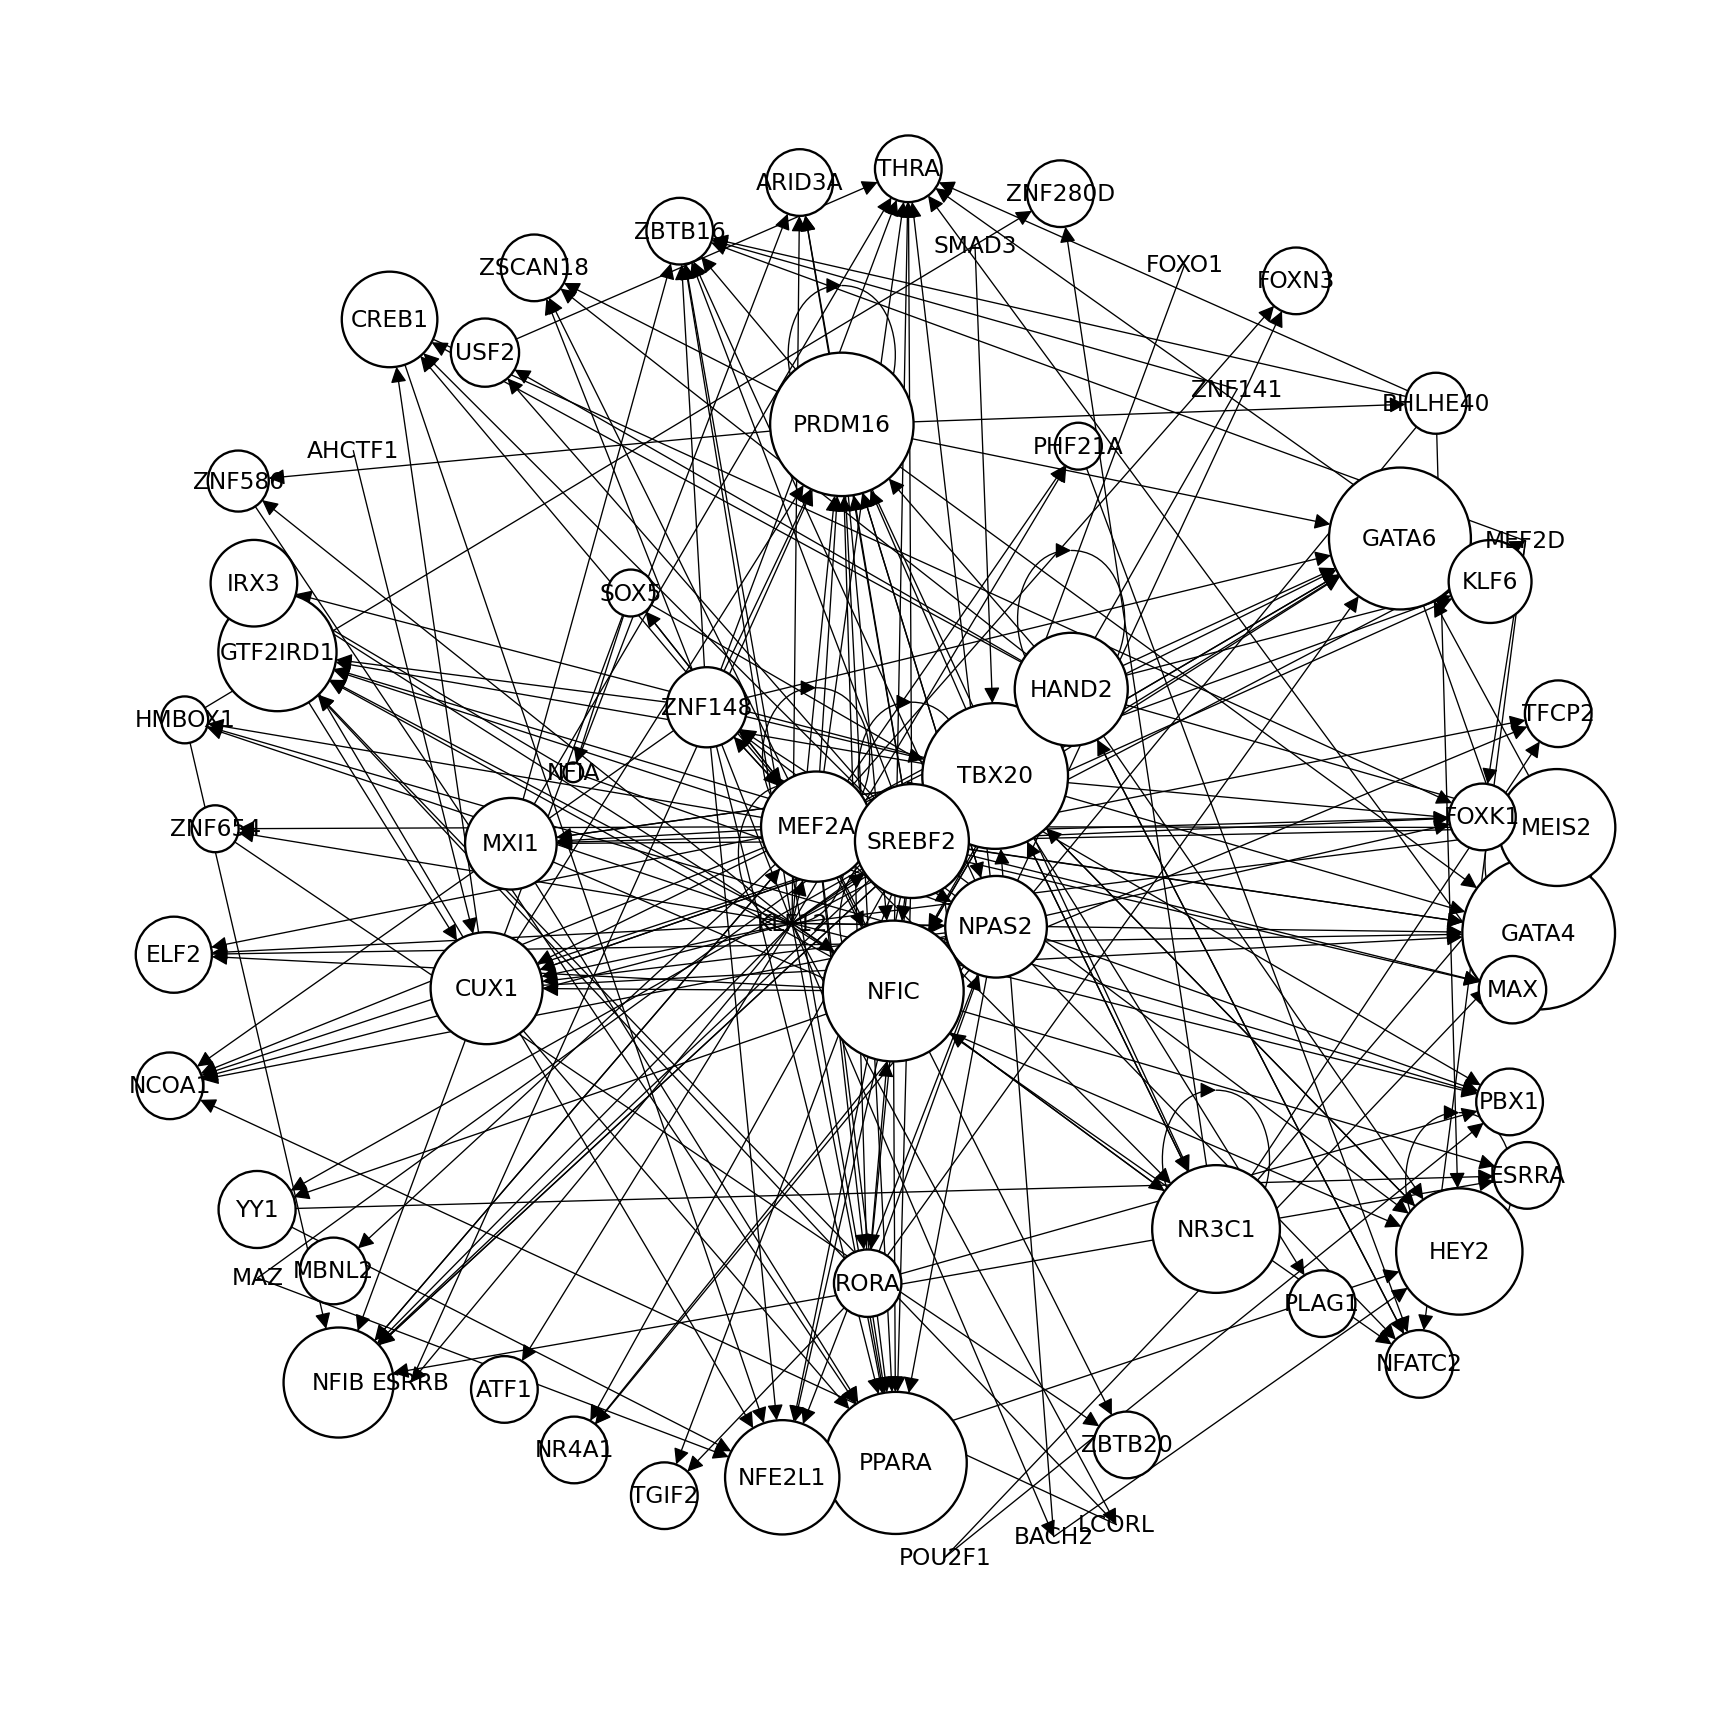

In [30]:
regulon_plot.draw_networkx(
    network=network_TF,
    nodes_color_base='white',
    nodes_to_color=None, # list
    nodes_color_highlight=None,
    nodes_size_base=400,
    nodes_size_map=node_size_map,
     spring_layout_k=1.5,
    spring_layout_scale=1.5,
    figsize =(7,7),
    random_seed=12,
    numpy_random_seed=100
    
)

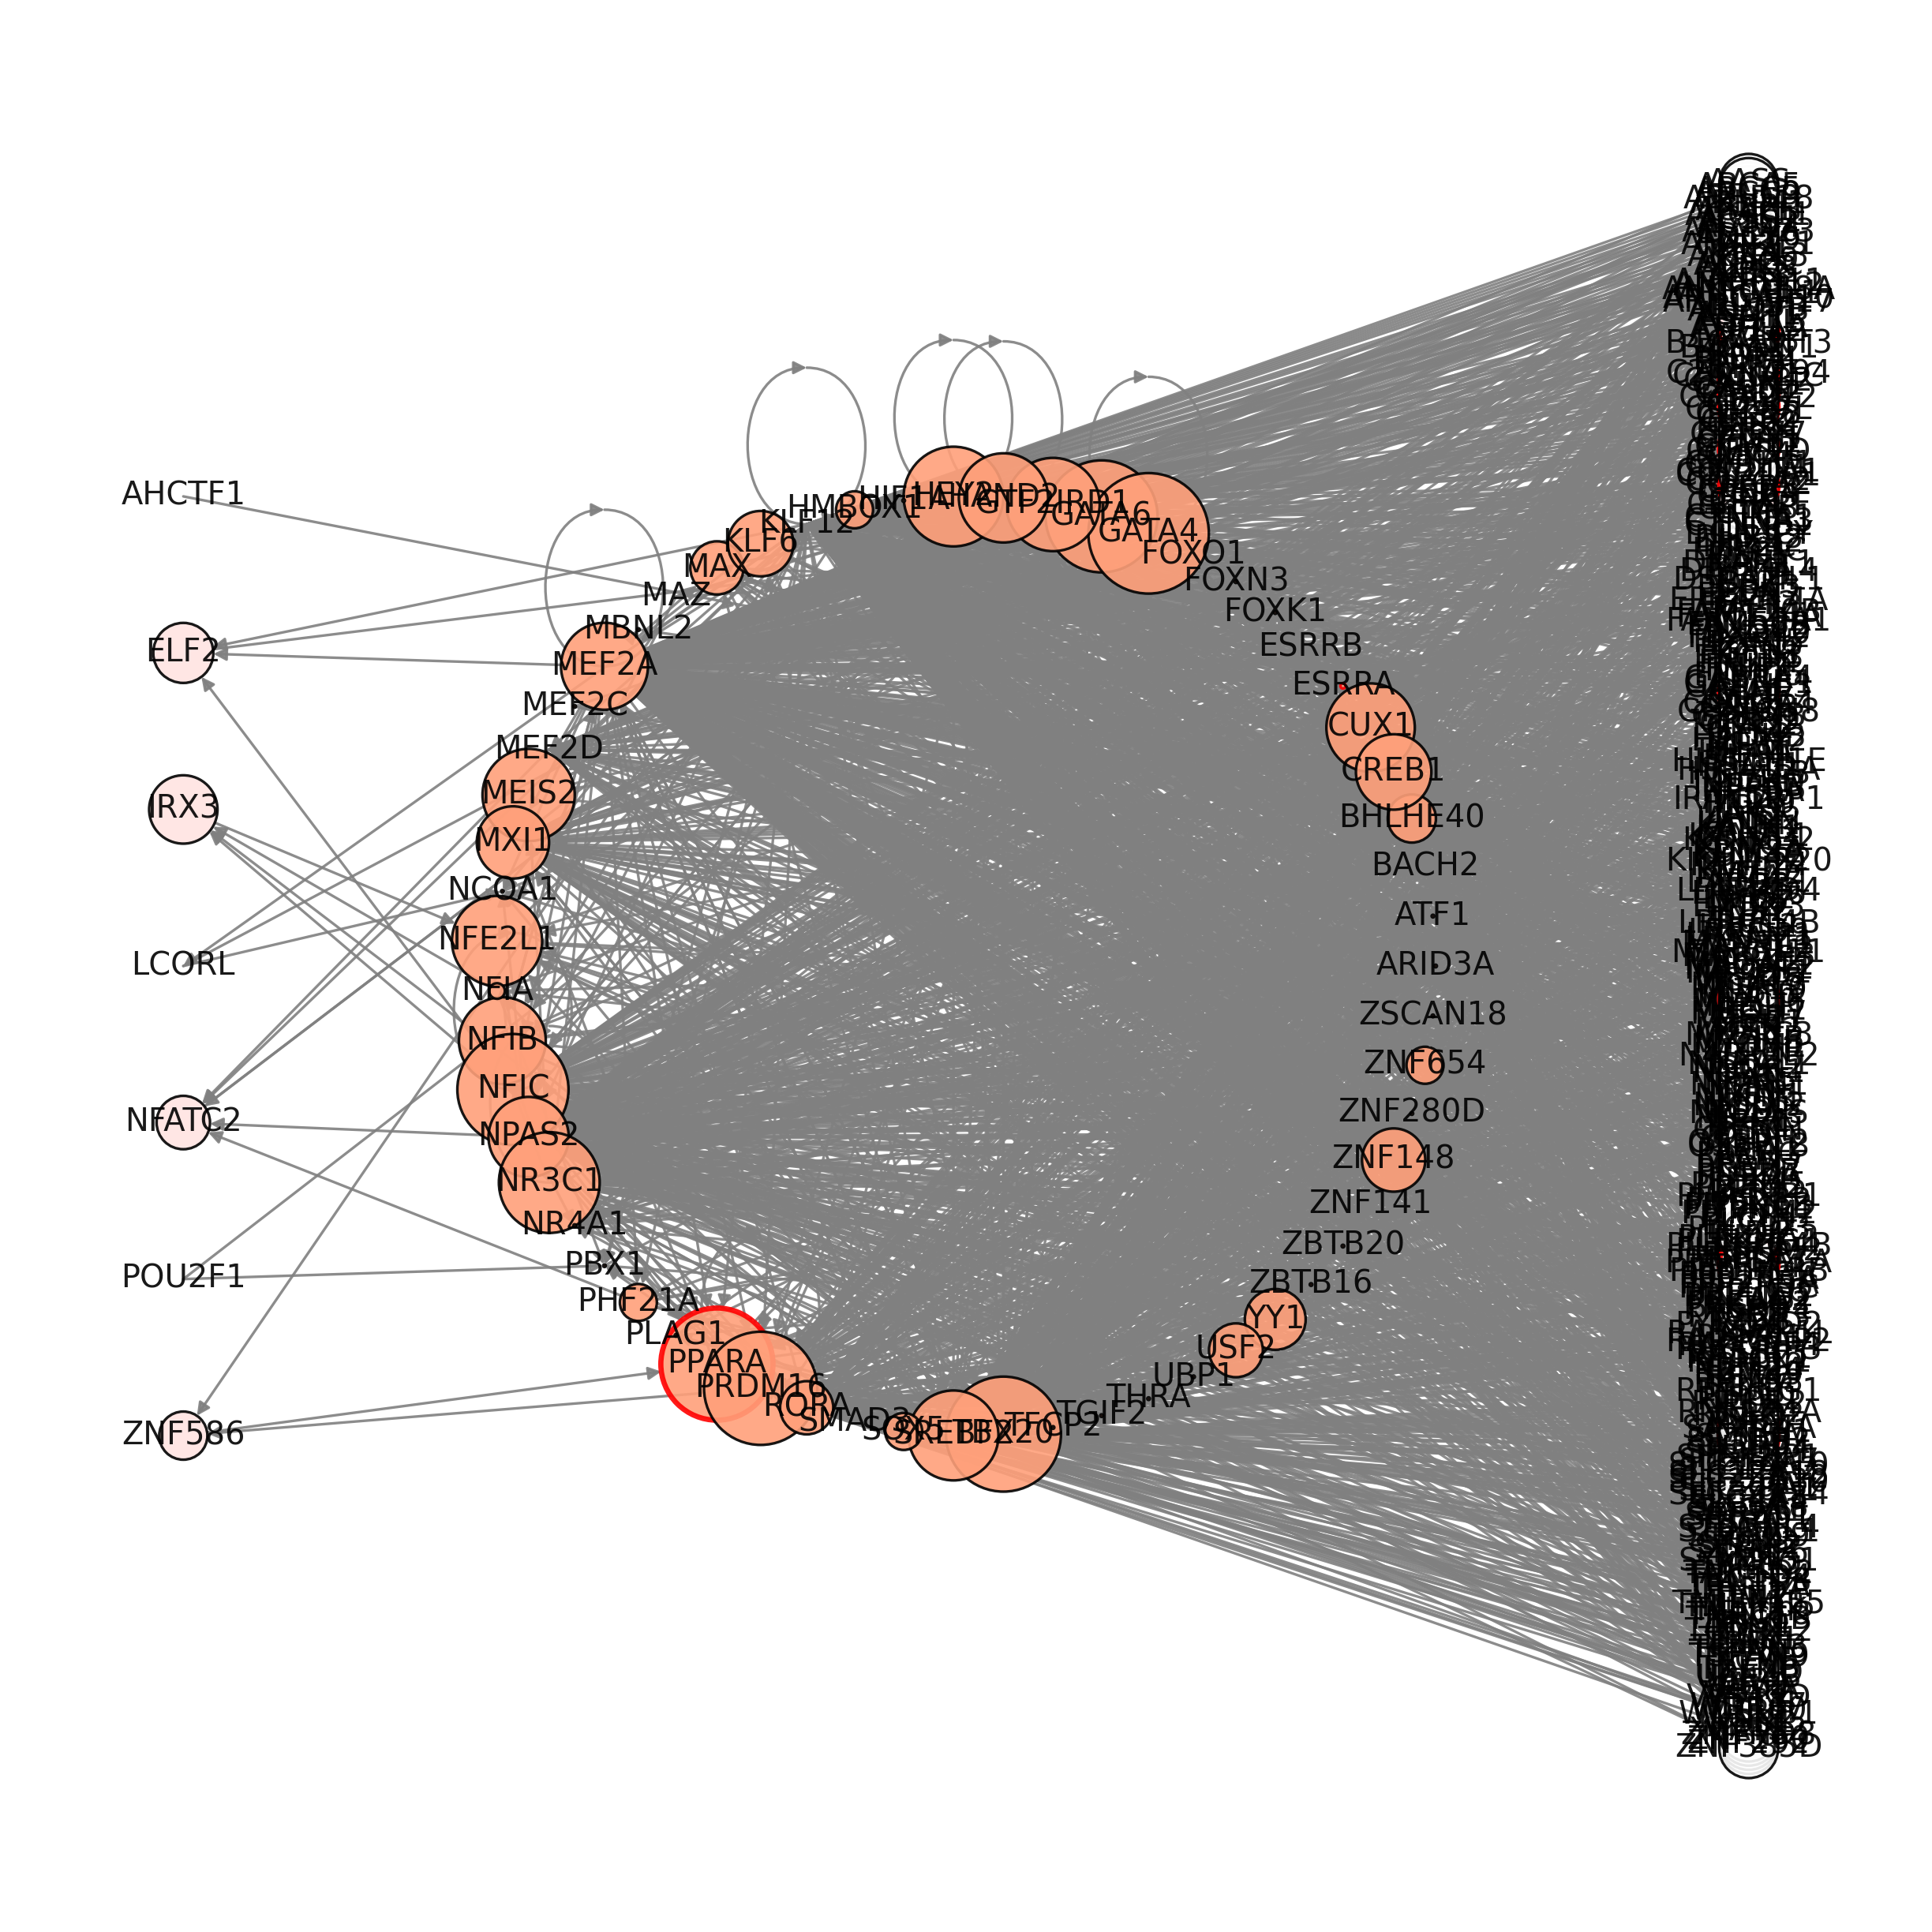

In [31]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
for tf, targets in network.items():
    G.add_node(tf, type='TF', size=node_size_map.get(tf, 1))  # Add TF node
    for tg in targets:
        if tg not in G:
            G.add_node(tg, type='TG', size=500)  # Add TG node if not already added
        G.add_edge(tf, tg)  # Add edge

# Define tf_nodes
tf_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'TF']
tg_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'TG']
tg_nodes.sort()

# Identifying direct and indirect TFs
direct_tfs = set()
for tf, targets in network.items():
    for tg in targets:
        if tg in tg_nodes:
            direct_tfs.add(tf)

indirect_tfs = list(set(tf_nodes) - direct_tfs)  # TFs that are not in direct TFs
direct_tfs = list(direct_tfs)
indirect_tfs.sort()
direct_tfs.sort()

# Manually creating circular positions for indirect and direct TFs, and linear positions for TGs
def create_circular_positions(node_list, center_x, center_y, radius):
    angle_step = 2 * np.pi / len(node_list)
    return {node: (center_x + np.cos(i * angle_step) * radius, center_y + np.sin(i * angle_step) * radius) 
            for i, node in enumerate(node_list)}

# Create circular positions for indirect and direct TFs
direct_tf_pos = create_circular_positions(direct_tfs, 0.5, 0.5, 0.3)

# Linear positions for indirect TFs
indirect_tf_x = [0 for _ in indirect_tfs]  # All nodes have the same x-coordinate
indirect_tf_y = np.linspace(0.8, 0.2, len(indirect_tfs))  # Evenly spaced y-coordinates
indirect_tf_pos = {indirect_tf: (x, y) for indirect_tf, x, y in zip(indirect_tfs, indirect_tf_x, indirect_tf_y)}

# Linear positions for TGs
tg_x = [1 for _ in tg_nodes]  # All TG nodes have the same x-coordinate
tg_y = np.linspace(1, 0, len(tg_nodes))  # Evenly spaced y-coordinates
tg_pos = {tg: (x, y) for tg, x, y in zip(tg_nodes, tg_x, tg_y)}

# Combine positions
pos = {**indirect_tf_pos, **direct_tf_pos, **tg_pos}

# Update node colors: indirect TFs to "lightskyblue"
for node in G.nodes:
    if node in indirect_tfs:
        G.nodes[node]['color'] = 'mistyrose'
    else:
        G.nodes[node]['color'] = 'lightsalmon' if G.nodes[node]['type'] == 'TF' else 'white'

# node colors
node_colors = [data['color'] for node, data in G.nodes(data=True)]

# node edge colors
# change color for the ones highly expressed in foetal vs adult
node_edge_colors = ['red' if node in marker_genes else 'black' for node in G.nodes()]
node_edge_widths = [2 if node in marker_genes else 1 for node in G.nodes()]
# node_shapes = ['s' if node in tg_nodes else 'o' for node in G.nodes()]

# Plotting with updated positions
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=[G.nodes[node]['size'] for node in G.nodes()], 
        edge_color='grey', alpha=0.9, 
        edgecolors=node_edge_colors, linewidths=node_edge_widths, node_shape="o")
# plt.title("TF-TG Network (Three Levels: Indirect TFs, Direct TFs, TGs)")
plt.show()

In [32]:
l = ['CD36', 'OSBPL2', 'PITPNC1', 'SREBF2', 'SLC27A1']
[x for x in l if x in sig_genes]

['CD36', 'OSBPL2', 'PITPNC1', 'SREBF2']

In [ ]:
sig_genes

# Correlation of peak cound and n_TF to bind

In [ ]:
df = scenic_meta_sel[['Region','TF']]
df.drop_duplicates(inplace=True)
df['TF_count'] = 1
df = df.groupby('Region').sum()
df.head()

In [ ]:
ad = adata_peak[:,df.index]
ad = ad[ad.obs['fine_grain']==cell_of_intest]
ad

In [ ]:
df[f'total_count, {cell_of_intest}'] = ad.to_df().sum().reindex(df.index)
plt.scatter(df['TF_count'],df[f'total_count, {cell_of_intest}'])
plt.xlabel('TF_count')
plt.ylabel(f'total_count, {cell_of_intest}')